# Set Questions
In the midst of an election, a newspaper has broken the story of an advisor on social mobility to the Mayor owning three homes, two of which are let on Airbnb (one of which is still council-owned housing!). The opposition has announced a plan to force all professional landlords to register their properties and face higher Council Tax rates claiming that Airbnb is ‘out of control’ in the capital.

The Mayor wants to understand the scale of the ‘problem’ and the likely impacts of the opposition’s proposal so that they can either adopt it (and show how responsive they are) or demonstrate how poorly thought-through the opposition’s proposal is (and show that they’re not ready to govern).

They have come to you—their team of data analysts and policy advisors—for a briefing supported by evidence and visualisations that they can use in their campaign communications. You are working in an information-poor environment, so you will need to make assumptions, justify them clearly, and show how they affect your conclusions. Use data, reasoning, and clear visualisation to build a persuasive and evidence-informed argument.

# 1. Is Airbnb ‘out of control’ in London?

The 90-day legal limit has been the primary policy to limit the growth of short-term rent in London, limiting the incentive for landlords. Hence, in order to find whether Airbnb is getting out of control, we can observe how many of them might violate such rules.

Additionally, another concern have risen over the professionalisation of Airbnb. While Airbnb and other short-term accomodations are originally meant for the sharing economy, boosting tourism and utilising empty residential accomodation. More hosts now own multiple listings and uses Airbnb and other platforms to earn substantial revenue professionally. 

The dataset utilised is Inside Airbnb's listing data in London on 15th June 2025. In their data, they also estimate the occupancy over the last 365 days using [their own occupancy model](https://insideairbnb.com/data-assumptions/).

We have categorise the risky Airbnb listings under these principles. 
- High risk: `estimated_occupancy_l365d > 90` and `host_listing >= 2`
- Intermediate risk: either condition
- Low risk: none of them

This allows us derive the Airbnb characteristics of each borough.


## Loading Packages

In [1]:
# Package Loading

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import glob
import os

import numpy as np

def nice_number(x):
    """Round x to a 'nice' human-friendly number: 1, 2, 5 × 10^n."""
    if x == 0:
        return 0
    exp = np.floor(np.log10(abs(x)))
    frac = abs(x) / (10 ** exp)

    if frac < 1.5:
        nice_frac = 1
    elif frac < 3:
        nice_frac = 2
    elif frac < 7:
        nice_frac = 5
    else:
        nice_frac = 10

    return np.sign(x) * nice_frac * (10 ** exp)


def make_ticks(vmin, vmax, nticks=5):
    # handle degenerate case
    if vmin == vmax:
        return np.array([vmin])

    data_range = vmax - vmin
    raw_step = data_range / nticks
    step = nice_number(raw_step)

    # round minimum UP to step
    start = np.ceil(vmin / step) * step

    # ticks strictly < vmax
    ticks = np.arange(start, vmax, step)

    # ensure vmin is first tick
    if not np.any(np.isclose(ticks, vmin)):
        ticks = np.insert(ticks, 0, vmin)

    # ensure vmax is last tick
    if not np.any(np.isclose(ticks, vmax)):
        ticks = np.append(ticks, vmax)

    # now apply the 10% gap rule at both ends
    length = vmax - vmin

    # remove second tick if it's too close to vmin
    if len(ticks) >= 3:
        gap_min = ticks[1] - ticks[0]
        if gap_min < 0.1 * length:
            ticks = np.delete(ticks, 1)

    # remove second-largest tick if it's too close to vmax
    if len(ticks) >= 3:  # re-check length after any deletion
        gap_max = ticks[-1] - ticks[-2]
        if gap_max < 0.1 * length:
            ticks = np.delete(ticks, -2)

    return ticks

## Preparing Data

UK 2025 LAD boundaries from [ONS Geography Portal](https://geoportal.statistics.gov.uk/datasets/857b2b0e728742f382f5594834cfa0df_0/explore)

UK 2021 LSOA boundaries from [ONS Geography Portal](https://geoportal.statistics.gov.uk/datasets/b976e08d5c894df3901963469bd4f84f_0/explore?location=52.695758%2C-2.465415%2C6.89)

UK 2021 LSOA (2021) to Electoral Ward (2025) to LAD (2025) Lookup from [ONS Geography Portal](https://geoportal.statistics.gov.uk/datasets/f29a49574cc84f6d8e6e59ce2d8efb18_0/explore)

Airbnb data frim Inside Airbnb

Estimated LSOA-level Population from 2019 to 2024 from [ONS](https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimatesnationalstatistics)

In [4]:
import pathlib
import requests
import pandas as pd

DATA_URL = "https://orca.casa.ucl.ac.uk/~jreades/data/20250615-London-listings.csv.gz"

DATA_DIR = pathlib.Path("large_data/listings/")
DATA_PATH = DATA_DIR / "london_listings.csv.gz"

DATA_DIR.mkdir(exist_ok=True)

if not DATA_PATH.exists():
    print(f"Downloading data from {DATA_URL}...")
    r = requests.get(DATA_URL)
    r.raise_for_status()
    DATA_PATH.write_bytes(r.content)
    print(f"Saved to {DATA_PATH}")
else:
    print(f"Using existing file: {DATA_PATH}")

listings = pd.read_csv(
    DATA_PATH,
    compression="gzip",   # optional but explicit
    usecols=[
        'id', 'host_id', 'host_neighbourhood', 'latitude', 'longitude',
        'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
        'price', 'minimum_nights', 'maximum_nights',
        'estimated_occupancy_l365d', 'estimated_revenue_l365d',
        'calculated_host_listings_count',
        'calculated_host_listings_count_entire_homes',
        'calculated_host_listings_count_private_rooms',
        'calculated_host_listings_count_shared_rooms'
    ]
)

# Cleaning the price column from strings to floats
listings['price'] = (
    listings['price']
    .str.replace('$', '', regex=False)
    .str.replace(',', '', regex=False)
    .astype(float)
)

Saved to large_data\listings\london_listings.csv.gz


In [67]:
# Loading LAD boundary data

# the data source: https://geoportal.statistics.gov.uk/datasets/857b2b0e728742f382f5594834cfa0df_0/explore

folder_path = 'large_data/boundaries/'
files = glob.glob(os.path.join(folder_path, '*LAD*.geojson'))
print(files)

gdf_lad = gpd.read_file(files[0])
gdf_lad = gdf_lad[['LAD25CD', 'LAD25NM', 'geometry']]
#gdf_lad = gdf_lad.drop(["FID","BNG_E","BNG_N","LONG","LAT","GlobalID"], axis = 1)

borough_list = ["City of London", "Westminster", "Kensington and Chelsea", "Hammersmith and Fulham", "Wandsworth", "Lambeth", "Southwark", "Tower Hamlets", 
                "Hackney", "Islington", "Camden", "Brent", "Ealing", "Hounslow", "Richmond upon Thames", "Kingston upon Thames", "Merton", "Sutton",
                "Croydon", "Bromley", "Lewisham", "Greenwich", "Bexley", "Havering", "Barking and Dagenham", "Redbridge", "Newham", "Waltham Forest", 
                "Haringey", "Enfield", "Barnet", "Harrow", "Hillingdon"]

gdf_lad = gdf_lad[(gdf_lad['LAD25NM'].isin(borough_list))]

if len(gdf_lad) == len(borough_list): print("Matching length: all boroughs selected")

gdf_lad = gdf_lad.to_crs("EPSG:27700")

gdf_lad["area_km2"] = gdf_lad.geometry.area / 1_000_000 

['large_data/boundaries\\LAD_MAY_2025_UK_BFC_V2_481919774574330966.geojson']
Matching length: all boroughs selected


In [7]:
import pathlib
import requests
import pandas as pd

DATA_URL = "https://liveuclac-my.sharepoint.com/:u:/g/personal/zcfaani_ucl_ac_uk/IQDaLl2VorwqQZXgnX_jd8SjARUSv2Q1sT_CMom0FpccDjc"

DATA_DIR = pathlib.Path("data/boundaries/")
DATA_PATH = DATA_DIR / "LSOA_(2021)_EW_BSC_V4_to_Rural_Urban_Classification.geojson"

DATA_DIR.mkdir(exist_ok=True)

if not DATA_PATH.exists():
    print(f"Downloading data from {DATA_URL}...")
    r = requests.get(DATA_URL)
    r.raise_for_status()
    DATA_PATH.write_bytes(r.content)
    print(f"Saved to {DATA_PATH}")
else:
    print(f"Using existing file: {DATA_PATH}")

Using existing file: data\boundaries\LSOA_(2021)_EW_BSC_V4_to_Rural_Urban_Classification.geojson


In [8]:
import pathlib
import requests
import pandas as pd

DATA_URL = "https://liveuclac-my.sharepoint.com/:x:/g/personal/zcfaani_ucl_ac_uk/IQB5RGevjB5tQ5HNJZmib_WNAeUE44ZchuQ49pwlwMWcZgI?e=xctkuw"

DATA_DIR = pathlib.Path("data/boundaries/")
DATA_PATH = DATA_DIR / "LSOA_(2021)_to_Electoral_Ward_(2025)_to_LAD_(2025)_Best_Fit_Lookup_in_EW_v2.csv"

DATA_DIR.mkdir(exist_ok=True)

if not DATA_PATH.exists():
    print(f"Downloading data from {DATA_URL}...")
    r = requests.get(DATA_URL)
    r.raise_for_status()
    DATA_PATH.write_bytes(r.content)
    print(f"Saved to {DATA_PATH}")
else:
    print(f"Using existing file: {DATA_PATH}")

ludf_lsoa = pd.read_csv(DATA_PATH)

Using existing file: data\boundaries\LSOA_(2021)_to_Electoral_Ward_(2025)_to_LAD_(2025)_Best_Fit_Lookup_in_EW_v2.csv


In [ ]:
# Loading LSOA boundary data

import pathlib
import requests
import pandas as pd

DATA_URL = "https://liveuclac-my.sharepoint.com/:x:/g/personal/zcfaani_ucl_ac_uk/IQB5RGevjB5tQ5HNJZmib_WNAeUE44ZchuQ49pwlwMWcZgI?e=xctkuw"

DATA_DIR = pathlib.Path("data/boundaries/")
DATA_PATH = DATA_DIR / "LSOA_(2021)_to_Electoral_Ward_(2025)_to_LAD_(2025)_Best_Fit_Lookup_in_EW_v2.csv"

DATA_DIR.mkdir(exist_ok=True)

if not DATA_PATH.exists():
    print(f"Downloading data from {DATA_URL}...")
    r = requests.get(DATA_URL)
    r.raise_for_status()
    DATA_PATH.write_bytes(r.content)
    print(f"Saved to {DATA_PATH}")
else:
    print(f"Using existing file: {DATA_PATH}")

gdf_lsoa = gpd.read_file(DATA_PATH)
gdf_lsoa = gdf_lsoa.drop(["FID","BNG_E","BNG_N","LONG","LAT","GlobalID"], axis = 1)


ludf_lsoa = pd.read_csv(f"{lookup_files[0]}")

ludf_lsoa = ludf_lsoa[(ludf_lsoa['LAD25NM'].isin(borough_list))]
gdf_lsoa = gdf_lsoa[(gdf_lsoa['LSOA21CD'].isin(ludf_lsoa['LSOA21CD']))]

gdf_lsoa = gdf_lsoa.merge(
    ludf_lsoa[['LSOA21CD', 'LAD25CD', 'LAD25NM']],
    on='LSOA21CD',
    how='left'
)

gdf_lsoa = gdf_lsoa[['LSOA21CD','LSOA21NM','LAD25CD','LAD25NM','geometry']]

gdf_lsoa = gdf_lsoa.to_crs(epsg=27700)

gdf_lsoa["area_km2"] = gdf_lsoa.geometry.area / 1_000_000 

In [69]:
# Loading and Cleaning population data

# Data Source: https://www.ons.gov.uk/peoplepopulationandcommunity/populationandmigration/populationestimates/datasets/lowersuperoutputareamidyearpopulationestimatesnationalstatistics

# The code can take upto 7 mins. You can directly load the processed data.
'''
pop_folder = "large_data/population/"

pop_files = glob.glob(os.path.join(pop_folder, 'sapelsoasyoa*.xlsx'))

#create an empty LSOA df
pop_df_lsoa= gdf_lsoa.copy()
pop_df_lsoa = pop_df_lsoa[['LSOA21CD','LSOA21NM','LAD25CD','LAD25NM','geometry']]

for file in pop_files:
    xlsx = pd.ExcelFile(file)
    pop_sheets = [f for f in xlsx.sheet_names if f.startswith("Mid-")]
    for sheet in pop_sheets:
        year = sheet[4:8]
        if f'total_{year}' not in pop_df_lsoa.columns:
            df = pd.read_excel(file, sheet_name=sheet, skiprows=3, usecols="A:E")
            df = df.rename(columns={
                    'LAD 2021 Code' : 'LAD21CD',
                    'LAD 2021 Name' : 'LAD21NM',
                    'LSOA 2021 Code': 'LSOA21CD',
                    'LSOA 2021 Name': 'LSOA21NM',
                    'Total'         : f'total_{year}',
                    'LAD 2023 Code' : 'LAD23CD',
                    'LAD 2023 Name' : 'LAD23NM',
                })
            print(f"Processing {sheet}: year {year}")
            #print(df.columns)
            pop_df_lsoa = pop_df_lsoa.merge(
                    df[['LSOA21CD',f'total_{year}']],
                    how = 'left',
                    on = 'LSOA21CD'
            )
            print(f"Adding new columns: 'total_{year}'")
        else: print(f"Skipping {sheet}")

pop_df_lsoa.to_csv("data/processed/pop_london_2019_2024.csv")

pop_cols = [c for c in pop_df_lsoa.columns if c.startswith('total_')]

pop_df_lad = (
    pop_df_lsoa
    .groupby(["LAD25CD", "LAD25NM"])[pop_cols]
    .sum()
    .reset_index()
)

pop_df_lsoa.to_csv("data/processed/pop_lsoa_2019_2024.csv")
pop_df_lad.to_csv("data/processed/pop_lad_2019_2024.csv")
'''

'\npop_folder = "large_data/population/"\n\npop_files = glob.glob(os.path.join(pop_folder, \'sapelsoasyoa*.xlsx\'))\n\n#create an empty LSOA df\npop_df_lsoa= gdf_lsoa.copy()\npop_df_lsoa = pop_df_lsoa[[\'LSOA21CD\',\'LSOA21NM\',\'LAD25CD\',\'LAD25NM\',\'geometry\']]\n\nfor file in pop_files:\n    xlsx = pd.ExcelFile(file)\n    pop_sheets = [f for f in xlsx.sheet_names if f.startswith("Mid-")]\n    for sheet in pop_sheets:\n        year = sheet[4:8]\n        if f\'total_{year}\' not in pop_df_lsoa.columns:\n            df = pd.read_excel(file, sheet_name=sheet, skiprows=3, usecols="A:E")\n            df = df.rename(columns={\n                    \'LAD 2021 Code\' : \'LAD21CD\',\n                    \'LAD 2021 Name\' : \'LAD21NM\',\n                    \'LSOA 2021 Code\': \'LSOA21CD\',\n                    \'LSOA 2021 Name\': \'LSOA21NM\',\n                    \'Total\'         : f\'total_{year}\',\n                    \'LAD 2023 Code\' : \'LAD23CD\',\n                    \'LAD 2023 Name

In [70]:
processed_folder = "data/processed/"
pop_df_lad = pd.read_csv(f"{processed_folder}pop_lad_2019_2024.csv").iloc[:, 1:]
pop_df_lsoa = pd.read_csv(f"{processed_folder}pop_lsoa_2019_2024.csv").iloc[:, 1:]

idx_col = 'LAD25CD'
gdf_lad = gdf_lad.merge(
        pop_df_lad[[idx_col]+[c for c in pop_df_lad.columns if c not in gdf_lad.columns]],
        how = 'left',
        on = idx_col
    )

idx_col2 = 'LSOA21CD'
gdf_lsoa = gdf_lsoa.merge(
        pop_df_lsoa[[idx_col2]+[c for c in pop_df_lsoa.columns if c not in gdf_lsoa.columns]],
        how = 'left',
        on = idx_col2
    )

## Risk Categorisation

In [71]:
# Filtering for "Entire home/apt" listings and short-term let (minimum nights under 30 days)
listings = listings[
    (listings['room_type'] == "Entire home/apt") &
    (listings['minimum_nights'] < 30)
]

# Risk No 1 over 90 days
listings['Risk_90d_rule'] = (listings['estimated_occupancy_l365d'] > 90).astype(int)

# Risk No 2 multiple listings
listings['Risk_multi_listing'] = (listings['calculated_host_listings_count'] > 1).astype(int)

# Risk: Sum
listings['Risk_combined'] = (listings['Risk_90d_rule'] + listings['Risk_multi_listing'])

In [72]:
listings = gpd.GeoDataFrame(
    listings.copy(),
    geometry=gpd.points_from_xy(listings['longitude'], listings['latitude']),
    crs="EPSG:4326"   # WGS84 (lat/lon)
)

# 1. Make sure CRS matches
listings = listings.to_crs("EPSG:27700")   # EPSG:27700 = OSGB 1936 / British National Grid

# 2. Spatial join: attach polygon attributes to points
# predicate can be "within", "contains", or "intersects"
listings = gpd.sjoin(
    listings,
    gdf_lsoa[['LSOA21CD', 'LSOA21NM', 'LAD25CD', 'LAD25NM', 'geometry']],
    how="left",
    predicate="within"   # or "intersects"
)

# Create weighted accommodates column
listings['weighted_accommodates'] = listings['accommodates'] * listings['estimated_occupancy_l365d'] / 365

# Convenience indicator columns for the groupby
listings = listings.assign(
    high_risk = (listings['Risk_combined'] == 2).astype(int),  # both risks
    only_90d_rule = (
        (listings['Risk_90d_rule'] == 1) &
        (listings['Risk_multi_listing'] == 0)
    ).astype(int),
    only_multi_listing = (
        (listings['Risk_90d_rule'] == 0) &
        (listings['Risk_multi_listing'] == 1)
    ).astype(int),
    low_risk = (listings['Risk_combined'] == 0).astype(int)   # no risks
)

# Group and aggregate
result_lsoa = (
    listings.groupby(["LSOA21CD", "LSOA21NM"])
    .agg(
        LAD25CD=('LAD25CD', "first"),
        LAD25NM=('LAD25NM', "first"),
        accom_sum=('accommodates', "sum"),
        w_accom_sum=('weighted_accommodates', "sum"),
        
        # 1. total listings in the group
        listings_count=('LSOA21CD', 'size'),  # any column would work here
        
        # 2–5. risk counts
        sum_high_risk=('high_risk', 'sum'),
        sum_only_90d_rule=('only_90d_rule', 'sum'),
        sum_only_multi_listings=('only_multi_listing', 'sum'),
        sum_low_risk=('low_risk', 'sum'),
    )
    .reset_index()
)

# Group and aggregate
result_lad = (
    listings.groupby(["LAD25CD", "LAD25NM"])
    .agg(
        accom_sum=('accommodates', "sum"),
        w_accom_sum=('weighted_accommodates', "sum"),
        
        # 1. total listings in the group
        listings_count=('LAD25CD', 'size'),  # any column would work here
        
        # 2–5. risk counts
        sum_high_risk=('high_risk', 'sum'),
        sum_only_90d_rule=('only_90d_rule', 'sum'),
        sum_only_multi_listings=('only_multi_listing', 'sum'),
        sum_low_risk=('low_risk', 'sum'),
    )
    .reset_index()
)

# ---- Merge back to polygons ----

# LAD level
idx_col = 'LAD25CD'
gdf_lad = gdf_lad.merge(
        result_lad[[idx_col]+[c for c in result_lad.columns if c not in gdf_lad.columns]],
        on = idx_col,
        how = 'left'
    )

# replace NaNs (no listings) with 0 for numeric columns
lad_num_cols = [
    'accom_sum', 'w_accom_sum', 'listings_count',
    'sum_high_risk', 'sum_only_90d_rule',
    'sum_only_multi_listings', 'sum_low_risk'
]
gdf_lad[lad_num_cols] = gdf_lad[lad_num_cols].fillna(0)


# LSOA level
idx_col2 = 'LSOA21CD'
gdf_lsoa = gdf_lsoa.merge(
        result_lsoa[[idx_col2]+[c for c in result_lsoa.columns if c not in gdf_lsoa.columns]],
        on = idx_col2,
        how = 'left'
    )

# replace NaNs (no listings) with 0 for numeric columns
lsoa_num_cols = [
    'accom_sum', 'w_accom_sum', 'listings_count',
    'sum_high_risk', 'sum_only_90d_rule',
    'sum_only_multi_listings', 'sum_low_risk'
]
gdf_lsoa[lsoa_num_cols] = gdf_lsoa[lsoa_num_cols].fillna(0)

## Visualisation but using Borough Instead. (Can be addition to Q1)

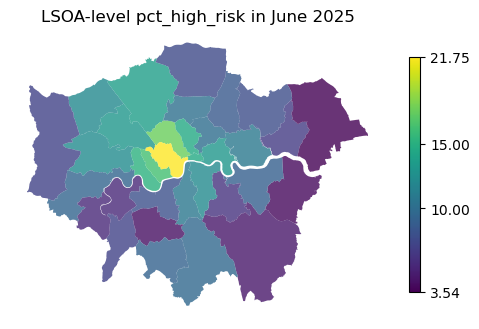

In [73]:
vis_df = gdf_lad.copy()
#vis_df = gdf_lsoa.copy()
#col = 'sum_high_risk'
col = 'pct_high_risk'
vis_df[col] = vis_df['sum_high_risk']*100/vis_df['listings_count']
t_m, t_y = 'June', 2025

min_scale, max_scale = vis_df[col].min(), vis_df[col].max()
gap = 5

fig, ax = plt.subplots(figsize=(5, 5))

vis_df.plot(
    column=col,
    categorical=False,
    legend=True,
    alpha=0.8,
    ax=ax,
    vmin=min_scale, 
    vmax=max_scale,
    legend_kwds={"shrink": 0.5, "ticks": list(make_ticks(min_scale,max_scale, gap))}
)

ax.set_title(f"LSOA-level {col} in {t_m} {t_y}")
ax.set_axis_off()

plt.tight_layout()
plt.show()

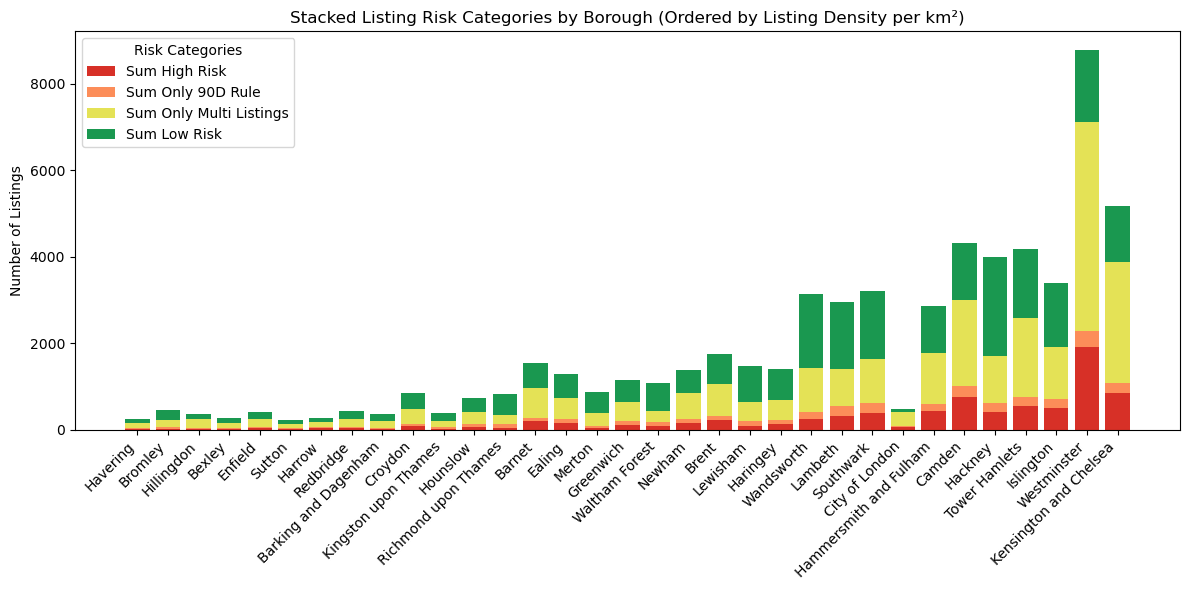

In [74]:
df = gdf_lad.copy()

# 1. Create density column
df['listings_density'] = df['listings_count'] / df['area_km2']

# 2. Sort by density (ascending; use descending=False for highest density first)
df_sorted = df.sort_values('listings_density', ascending=True)

risk_cols = [
    'sum_high_risk',
    'sum_only_90d_rule',
    'sum_only_multi_listings',
    'sum_low_risk'
]

# Custom palette
colours = {
    'sum_high_risk': "#d73027",           # red
    'sum_only_90d_rule': "#fc8d59",       # orange
    'sum_only_multi_listings': "#e4e256", # yellow
    'sum_low_risk': "#1a9850"             # green
}

boroughs = df_sorted['LAD25NM']
x = np.arange(len(boroughs))

bottom = np.zeros(len(df_sorted))

plt.figure(figsize=(12, 6))

for col in risk_cols:
    plt.bar(
        x,
        df_sorted[col],
        bottom=bottom,
        label=col.replace('_', ' ').title(),
        color=colours[col]          # ← apply custom palette here
    )
    bottom += df_sorted[col]

plt.xticks(x, boroughs, rotation=45, ha='right')
plt.ylabel("Number of Listings")
plt.title("Stacked Listing Risk Categories by Borough (Ordered by Listing Density per km²)")
plt.legend(title="Risk Categories")
plt.tight_layout()
plt.show()


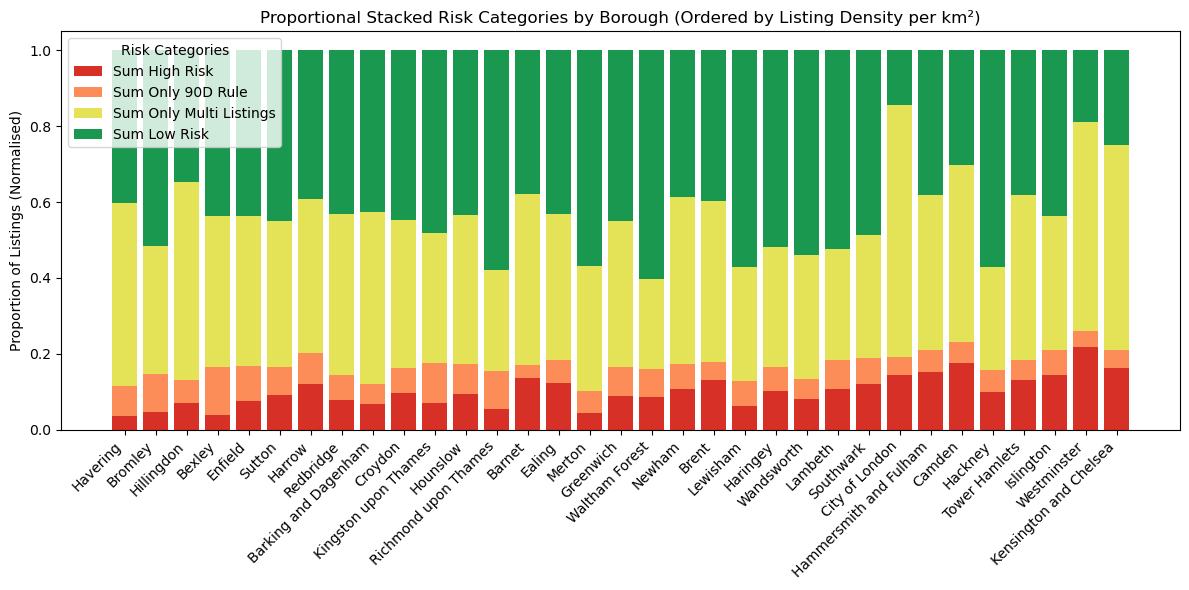

In [75]:
df = gdf_lad.copy()

# 1. Create density column
df['listings_density'] = df['listings_count'] / df['area_km2']

# 2. Sort by density
df_sorted = df.sort_values('listings_density', ascending=True)

risk_cols = [
    'sum_high_risk',
    'sum_only_90d_rule',
    'sum_only_multi_listings',
    'sum_low_risk'
]

# Custom palette
colours = {
    'sum_high_risk': "#d73027",
    'sum_only_90d_rule': "#fc8d59",
    'sum_only_multi_listings': "#e4e256",
    'sum_low_risk': "#1a9850"
}

# 3. Normalise values so each row sums to 1
df_norm = df_sorted.copy()
row_totals = df_norm[risk_cols].sum(axis=1)
df_norm[risk_cols] = df_norm[risk_cols].div(row_totals, axis=0)

boroughs = df_sorted['LAD25NM']
x = np.arange(len(boroughs))
bottom = np.zeros(len(df_norm))

plt.figure(figsize=(12, 6))

for col in risk_cols:
    plt.bar(
        x,
        df_norm[col],
        bottom=bottom,
        label=col.replace('_', ' ').title(),
        color=colours[col]
    )
    bottom += df_norm[col]

plt.xticks(x, boroughs, rotation=45, ha='right')
plt.ylabel("Proportion of Listings (Normalised)")
plt.title("Proportional Stacked Risk Categories by Borough (Ordered by Listing Density per km²)")
plt.legend(title="Risk Categories")
plt.tight_layout()
plt.show()

In [76]:
gdf_lad.to_csv("test.csv")

In [77]:
# Visualising them

In [78]:
# Visualising them

Consequently, it is clear that more than 50% of all properties on Airbnb might violate the 90-day rule. The existing rule is unenforced despite the platform immediate stop once the listing reaches the limit. 

However, comparing to the local population, the Airbnb capacity is highly limited in most area even in Central London, suggesting that despite the concerning rule enforcement. The whole Airbnb is still under control.

# 2. How many professional landlords are there?

As 

**Suggested Methodology**

*Done* count over 2 listings.

count which borough are most host from.

**Assumption:** the pattern of host locations might change considering many people hire a company to manage their properties. Hence, this can change if the opposition's policy is used.

In [98]:
hosts = (
    listings
    .groupby("host_id", as_index=False)
    .agg(

        raw_listings_count=("id", "size"),  # count of rows per host

        # sum for this column
        estimated_revenue_l365d=("estimated_revenue_l365d", "sum"),
        Risk_90d_rule=("Risk_90d_rule", "sum"),
        
        calculated_host_listings_count=("calculated_host_listings_count", "sum"),
        calculated_host_listings_count_entire_homes=("calculated_host_listings_count_entire_homes", "sum"),
        calculated_host_listings_count_private_rooms=("calculated_host_listings_count_private_rooms", "sum"),
        calculated_host_listings_count_shared_rooms=("calculated_host_listings_count_shared_rooms", "sum"),

        # keep columns where you want the first occurrence
        host_neighbourhood=("host_neighbourhood", "first"),

        # keep the list
        id=("id", list),
        LAD25NM=("LAD25NM", list),
        accommodates=("accommodates", list),
        weighted_accommodates=("weighted_accommodates", list),
        estimated_occupancy_l365d=("estimated_occupancy_l365d", list),
    )
)

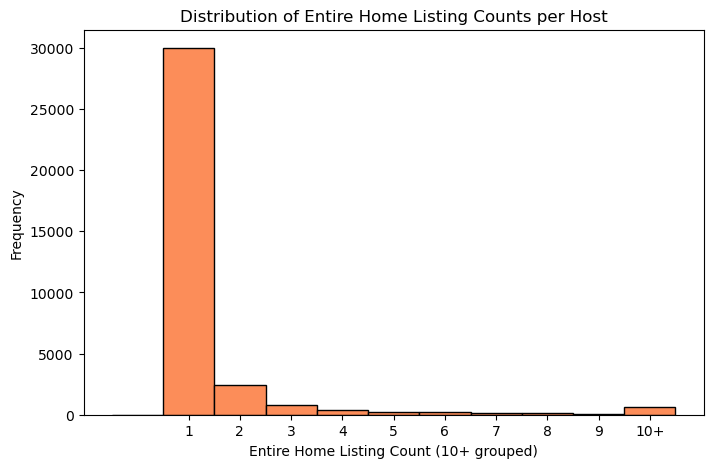

In [117]:
# Variable
x = hosts["raw_listings_count"]

# Cap values > 10
x_capped = x.clip(upper=10)

# Bins: 0–1, 1–2, ..., 9–10, 10+
bins = np.arange(0, 12, 1)

plt.figure(figsize=(8, 5))
plt.hist(x_capped, bins=bins, color= "#fc8d59" ,edgecolor='black')

plt.title("Distribution of Entire Home Listing Counts per Host")
plt.xlabel("Entire Home Listing Count (10+ grouped)")
plt.ylabel("Frequency")

# Create tick labels starting from 1
tick_labels = [str(i) for i in range(1, 10)] + ["10+"]

# Tick positions: center of each bin = 1.5, 2.5, ..., 10.5
tick_positions = np.arange(1.5, 11.5, 1)

plt.xticks(tick_positions, tick_labels)

plt.show()

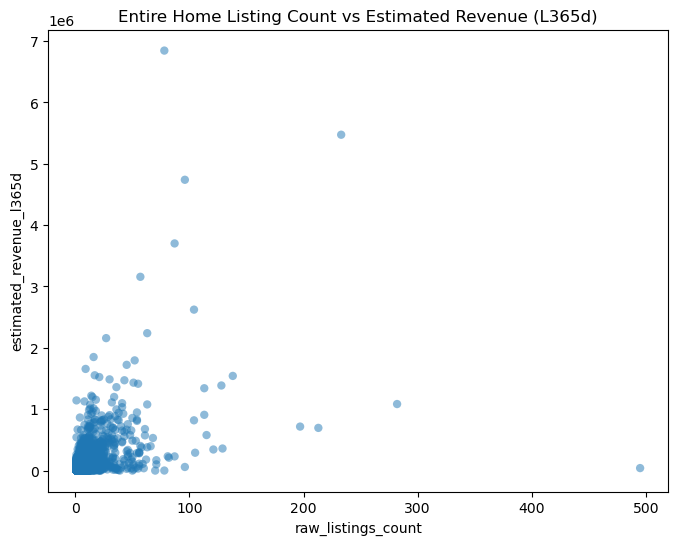

In [ ]:
x = hosts["raw_listings_count"]
y = hosts["estimated_revenue_l365d"]

plt.figure(figsize=(8, 6))
plt.scatter(x, y, alpha=0.5, edgecolors="none")

plt.title("Entire Home Listing Count vs Estimated Revenue (L365d)")
plt.xlabel("raw_listings_count")
plt.ylabel("estimated_revenue_l365d")

plt.show()

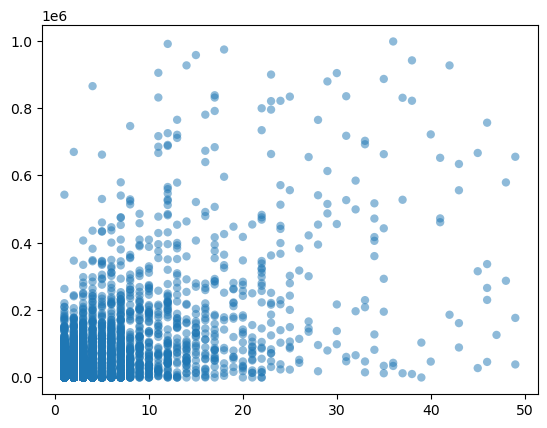

In [108]:
filtered = hosts[(hosts["raw_listings_count"] < 50) &
                 (hosts["estimated_revenue_l365d"] < 1_000_000)]

plt.scatter(filtered["raw_listings_count"], filtered["estimated_revenue_l365d"],
            alpha=0.5, edgecolors="none")

In [109]:
central_london_borough = ["City of London", "Westminster", "Kensington and Chelsea", "Camden", "Islington", "Hackney", 
                          "Hammersmith and Fulham", "Lambeth", "Southwark", "Tower Hamlets", "Wandsworth"]

listings_cl = listings[listings['LAD25NM'].isin(central_london_borough)]

In [110]:
hosts_cl = (
    listings_cl
    .groupby("host_id", as_index=False)
    .agg(

        raw_listings_count=("id", "size"),  # count of rows per host

        # sum for this column
        estimated_revenue_l365d=("estimated_revenue_l365d", "sum"),
        Risk_90d_rule=("Risk_90d_rule", "sum"),
        
        calculated_host_listings_count=("calculated_host_listings_count", "sum"),
        calculated_host_listings_count_entire_homes=("calculated_host_listings_count_entire_homes", "sum"),
        calculated_host_listings_count_private_rooms=("calculated_host_listings_count_private_rooms", "sum"),
        calculated_host_listings_count_shared_rooms=("calculated_host_listings_count_shared_rooms", "sum"),

        # keep columns where you want the first occurrence
        host_neighbourhood=("host_neighbourhood", "first"),

        # keep the list
        id=("id", list),
        LAD25NM=("LAD25NM", list),
        accommodates=("accommodates", list),
        weighted_accommodates=("weighted_accommodates", list),
        estimated_occupancy_l365d=("estimated_occupancy_l365d", list),
    )
)

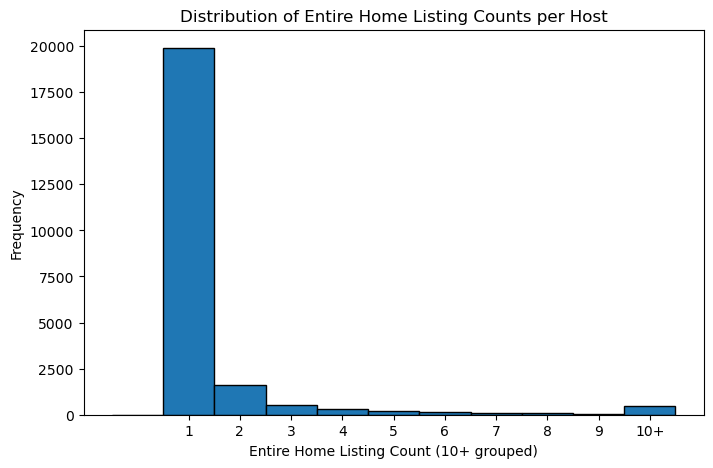

In [112]:
# Variable
x = hosts_cl["raw_listings_count"]

# Cap values > 10
x_capped = x.clip(upper=10)

# Bins: 0–1, 1–2, ..., 9–10, 10+
bins = np.arange(0, 12, 1)

plt.figure(figsize=(8, 5))
plt.hist(x_capped, bins=bins, edgecolor="black")

plt.title("Distribution of Entire Home Listing Counts per Host")
plt.xlabel("Entire Home Listing Count (10+ grouped)")
plt.ylabel("Frequency")

# Create tick labels starting from 1
tick_labels = [str(i) for i in range(1, 10)] + ["10+"]

# Tick positions: center of each bin = 1.5, 2.5, ..., 10.5
tick_positions = np.arange(1.5, 11.5, 1)

plt.xticks(tick_positions, tick_labels)

plt.show()

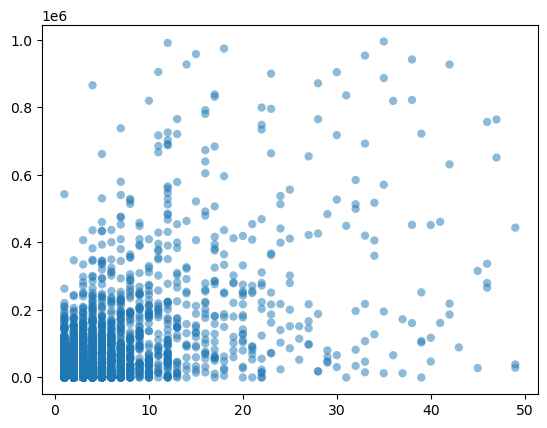

In [113]:
filtered = hosts_cl[(hosts_cl["raw_listings_count"] < 50) &
                 (hosts_cl["estimated_revenue_l365d"] < 1_000_000)]

plt.scatter(filtered["raw_listings_count"], filtered["estimated_revenue_l365d"],
            alpha=0.5, edgecolors="none")

In [ ]:
neighbourhood_to_borough = {
    "Shoreditch": "Hackney",
    "Dalston": "Hackney",
    "Haggerston": "Hackney",
    "Hackney Wick": "Hackney",
    "Brixton": "Lambeth",
    "Brixton Hill": "Lambeth",
    "Clapham": "Lambeth",
    "Stockwell": "Lambeth",
    "Peckham": "Southwark",
    "Camberwell": "Southwark",
    "Elephant and Castle": "Southwark",
    "Herne Hill": "Lambeth",
    "Forest Hill": "Lewisham",
    "Catford": "Lewisham",
    "Deptford": "Lewisham",
    "Blackheath": "Lewisham",
    "Bow": "Tower Hamlets",
    "Bethnal Green": "Tower Hamlets",
    "Mile End": "Tower Hamlets",
    "Whitechapel": "Tower Hamlets",
    "Poplar": "Tower Hamlets",
    "Wapping": "Tower Hamlets",
    "Stratford": "Newham",
    "West Ham": "Newham",
    "Canning Town": "Newham",
    "Tottenham": "Haringey",
    "Highgate": "Haringey",
    "Muswell Hill": "Haringey",
    "Acton": "Ealing",
    "Ealing": "Ealing",
    "Hanwell": "Ealing",
    "Shepherd's Bush": "Hammersmith and Fulham",
    "Fulham": "Hammersmith and Fulham",
    "Hammersmith": "Hammersmith and Fulham",
    "Chelsea": "Kensington and Chelsea",
    "Notting Hill": "Kensington and Chelsea",
    "South Kensington": "Kensington and Chelsea",
    "Kensington": "Kensington and Chelsea",
    "Putney": "Wandsworth",
    "Wandsworth": "Wandsworth",
    "Balham": "Wandsworth",
    "Tooting": "Wandsworth",
    "Wimbledon": "Merton",
    "Raynes Park": "Merton",
    "Colliers Wood": "Merton",
    "Greenwich": "Greenwich",
    "Charlton": "Greenwich",
    "Woolwich": "Greenwich",
    "Battersea": "Wandsworth",
    "Nine Elms": "Wandsworth",
    "South Bank": "Lambeth",
}


# 3. How many properties would be affected by the opposition’s proposal?

In [ ]:
# count the property listed by people with more than 2 listings. "Done"
# which area then?

# where are the host and the pattern of the listings and the hosts.
    # so that we can justify whether which borough is losing their revenue more than another because airbnb doesn't need to pay the council tax.
    # becuase airbnb can apply for business rating and use the small business scheme that the business rating might be exempt or be nearly nothing.



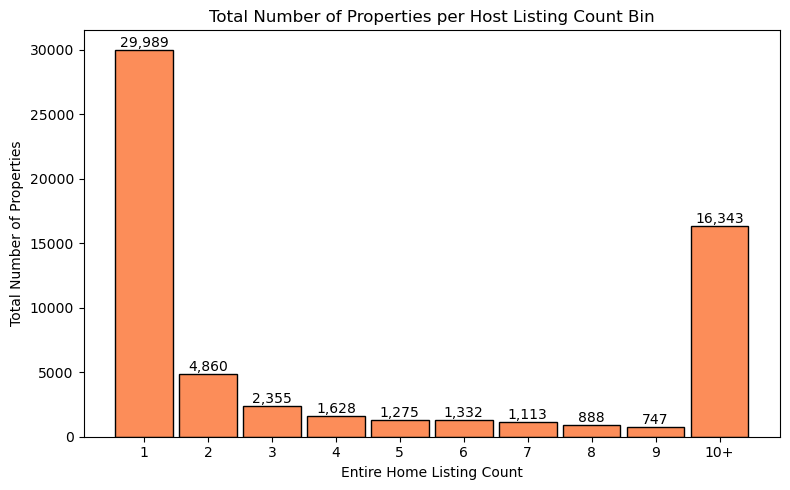

In [119]:
import numpy as np
import matplotlib.pyplot as plt

# Raw counts (no capping for calculations)
x = hosts["raw_listings_count"]

# For binning we still cap at 10+, but we keep original data for computation
x_capped = x.clip(upper=10)

# Bins: 0–1, 1–2, ..., 9–10, 10+
bins = np.arange(0, 12, 1)

# Histogram counts using capped values
counts, edges = np.histogram(x_capped, bins=bins)

# Compute total number of properties per bin
properties_per_bin = []

# For bins 1–9: multiply count by the bin number
for i in range(1, 10):
    properties_per_bin.append(counts[i] * i)

# For bin 10+: sum true raw counts for hosts where raw_listings_count >= 10
true_10plus_total = x[x >= 10].sum()
properties_per_bin.append(true_10plus_total)

# X positions for bars
bin_positions = np.arange(1, 11)

plt.figure(figsize=(8, 5))
bars = plt.bar(bin_positions, properties_per_bin, width=0.9,
               color="#fc8d59", edgecolor="black")

plt.title("Total Number of Properties per Host Listing Count Bin")
plt.xlabel("Entire Home Listing Count")
plt.ylabel("Total Number of Properties")

# Tick labels
tick_labels = [str(i) for i in range(1, 10)] + ["10+"]
plt.xticks(bin_positions, tick_labels)

# -----------------------------
# ✅ Add value labels on top of bars
# -----------------------------
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height:,}",         # formatted with commas
        ha="center",
        va="bottom",
        fontsize=10
    )

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# hosts has:
#   - raw_listings_count: number of properties per host
#   - LAD25NM: list of boroughs, one per property

# 1. Explode so each row = one property
props = hosts.explode("LAD25NM").reset_index(drop=True)

# 2. Define bins for host listing count: 1,2,...,9,10+
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, np.inf]
bin_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10+"]

props["bin"] = pd.cut(
    props["raw_listings_count"],
    bins=bins,
    labels=bin_labels,
    right=False,        # [1,2), [2,3), ..., [9,10), [10, inf)
    include_lowest=True
)

# 3. Number of properties per borough per bin
#    (each row is a single property now)
df_grouped = (
    props
    .groupby(["LAD25NM", "bin"])
    .size()
    .unstack(fill_value=0)
)

# Ensure bins in the desired order
df_grouped = df_grouped[bin_labels]

# OPTIONAL: focus on top N boroughs by total properties
top_boroughs = df_grouped.sum(axis=1).sort_values(ascending=False).head(10).index
df_grouped = df_grouped.loc[top_boroughs]

# 4. Plot stacked bar chart
plt.figure(figsize=(12, 6))

bottom = np.zeros(len(bin_labels), dtype=float)

for borough in df_grouped.index:
    values = df_grouped.loc[borough].values
    plt.bar(bin_labels, values, bottom=bottom, label=borough)
    bottom += values

plt.title("Number of Properties by Borough and Host Listing Count Bin")
plt.xlabel("Host's Entire Home Listing Count (binned)")
plt.ylabel("Number of Properties")

plt.legend(
    title="Borough (LAD25NM)",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_42088\1403769176.py:28: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["LAD25NM", "bin"])


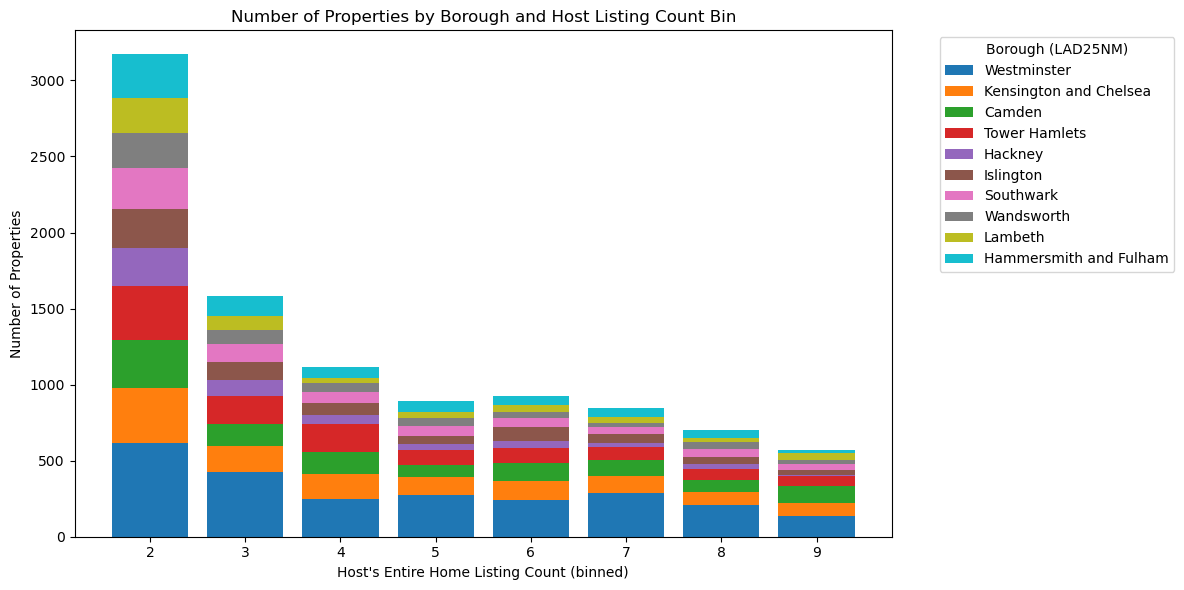

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# hosts has:
#   - raw_listings_count: number of properties per host
#   - LAD25NM: list of boroughs, one per property

# 1. Explode so each row = one property
props = hosts.explode("LAD25NM").reset_index(drop=True)

# 2. Define bins for host listing count: 1,2,...,9,10+
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, np.inf]
bin_labels = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10+"]

props["bin"] = pd.cut(
    props["raw_listings_count"],
    bins=bins,
    labels=bin_labels,
    right=False,        # [1,2), [2,3), ..., [9,10), [10, inf)
    include_lowest=True
)

# 3. Number of properties per borough per bin
#    (each row is a single property now)
df_grouped = (
    props
    .groupby(["LAD25NM", "bin"])
    .size()
    .unstack(fill_value=0)
)

# Ensure bins in the desired order
df_grouped = df_grouped[bin_labels]

# OPTIONAL: focus on top N boroughs by total properties
top_boroughs = df_grouped.sum(axis=1).sort_values(ascending=False).head(10).index
df_grouped = df_grouped.loc[top_boroughs]
df_grouped = df_grouped.drop(columns=["1", "10+"])
bin_labels = bin_labels[1:-1]

# 4. Plot stacked bar chart
plt.figure(figsize=(12, 6))

bottom = np.zeros(len(bin_labels), dtype=float)

for borough in df_grouped.index:
    values = df_grouped.loc[borough].values
    plt.bar(bin_labels, values, bottom=bottom, label=borough)
    bottom += values

plt.title("Number of Properties by Borough and Host Listing Count Bin")
plt.xlabel("Host's Entire Home Listing Count (binned)")
plt.ylabel("Number of Properties")

plt.legend(
    title="Borough (LAD25NM)",
    bbox_to_anchor=(1.05, 1),
    loc="upper left"
)

plt.tight_layout()
plt.show()

In [152]:
bin_labels

['1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']

In [148]:
df_grouped

bin,1,2,3,4,5,6,7,8,9,10+
LAD25NM,,,,,,,,,,
Westminster,2177,617,426,250,277,239,288,207,136,4157
Kensington and Chelsea,1640,361,168,163,117,129,109,85,84,2320
Camden,1667,316,147,146,79,120,110,80,111,1533
Tower Hamlets,2027,356,181,183,100,93,80,76,68,1010
Hackney,2771,251,111,59,35,47,26,32,9,654
Islington,1875,256,117,78,54,92,61,47,31,788
Southwark,1954,268,119,73,68,61,45,50,41,526
Wandsworth,1998,231,89,61,52,42,31,44,24,558
Lambeth,1954,231,90,32,37,46,35,30,47,455


In [ ]:
props = hosts.explode("LAD25NM").reset_index(drop=True)

bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, np.inf]
bin_labels = ["Prop_1", "Prop_2", "Prop_3", "Prop_4", "Prop_5",
              "Prop_6", "Prop_7", "Prop_8", "Prop_9", "Prop_10plus"]

props["bin"] = pd.cut(
    props["raw_listings_count"],
    bins=bins,
    labels=bin_labels,
    right=False,       # [1,2), [2,3), ..., [9,10), [10,∞)
    include_lowest=True
)

df_LAD_props = (
    props
    .groupby(["LAD25NM", "bin"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=bin_labels)   # ensure correct order
)



C:\Users\Lenovo\AppData\Local\Temp\ipykernel_42088\2620828769.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["LAD25NM", "bin"])


In [131]:
import numpy as np
import pandas as pd

# -----------------------------
# 1. EXPLODE so each row = one property
# -----------------------------
props = hosts.explode("LAD25NM").reset_index(drop=True)

# -----------------------------
# 2. Create bins for host listing count
# -----------------------------
bins = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, np.inf]
bin_labels = [
    "Prop_1", "Prop_2", "Prop_3", "Prop_4", "Prop_5",
    "Prop_6", "Prop_7", "Prop_8", "Prop_9", "Prop_10plus"
]

props["bin"] = pd.cut(
    props["raw_listings_count"],
    bins=bins,
    labels=bin_labels,
    right=False,         # [1,2), [2,3), ..., [9,10), [10,∞)
    include_lowest=True
)

# -----------------------------
# 3. Count properties per LAD25NM × listing-count bin
# -----------------------------
df_LAD_props = (
    props
    .groupby(["LAD25NM", "bin"])
    .size()
    .unstack(fill_value=0)
    .reindex(columns=bin_labels)
)

# -----------------------------
# 4. Add Total_Prop
# -----------------------------
df_LAD_props["Total_Prop"] = df_LAD_props.sum(axis=1)

# -----------------------------
# 5. Add percentage columns
# -----------------------------
for col in bin_labels:
    df_LAD_props[f"pct_{col}"] = (
        df_LAD_props[col] / df_LAD_props["Total_Prop"]
    )

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_42088\3145250304.py:31: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["LAD25NM", "bin"])


In [132]:
df_LAD_props.head()

bin,Prop_1,Prop_2,Prop_3,Prop_4,Prop_5,Prop_6,Prop_7,Prop_8,Prop_9,Prop_10plus,...,pct_Prop_1,pct_Prop_2,pct_Prop_3,pct_Prop_4,pct_Prop_5,pct_Prop_6,pct_Prop_7,pct_Prop_8,pct_Prop_9,pct_Prop_10plus
LAD25NM,,,,,,,,,,,,,,,,,,,,,
Barking and Dagenham,181,49,31,3,9,11,3,9,2,58,...,0.508427,0.137640,0.087079,0.008427,0.025281,0.030899,0.008427,0.025281,0.005618,0.162921
Barnet,690,124,65,40,49,41,37,17,24,462,...,0.445449,0.080052,0.041963,0.025823,0.031633,0.026469,0.023886,0.010975,0.015494,0.298257
Bexley,170,31,13,10,6,9,5,1,3,31,...,0.609319,0.111111,0.046595,0.035842,0.021505,0.032258,0.017921,0.003584,0.010753,0.111111
Brent,842,136,76,37,25,20,32,26,18,532,...,0.482798,0.077982,0.043578,0.021216,0.014335,0.011468,0.018349,0.014908,0.010321,0.305046
Bromley,312,41,21,16,13,9,8,6,7,32,...,0.670968,0.088172,0.045161,0.034409,0.027957,0.019355,0.017204,0.012903,0.015054,0.068817


In [135]:
temp_lad = gdf_lad.merge(
    df_LAD_props,
    how = "left",
    on = "LAD25NM"
)

In [145]:
temp_lad["pct_Prop_2plus"] = (
    temp_lad["pct_Prop_2"]
    + temp_lad["pct_Prop_3"]
    + temp_lad["pct_Prop_4"]
    + temp_lad["pct_Prop_5"]
    + temp_lad["pct_Prop_6"]
    + temp_lad["pct_Prop_7"]
    + temp_lad["pct_Prop_8"]
    + temp_lad["pct_Prop_9"]
    + temp_lad["pct_Prop_10plus"]
)


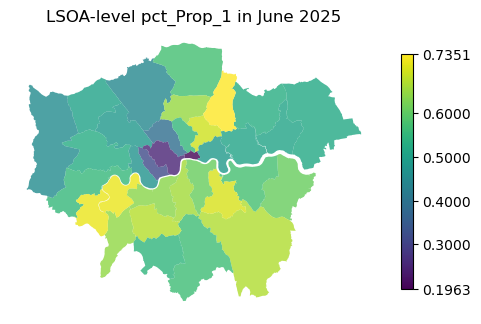

In [147]:
vis_df = temp_lad.copy()
#vis_df = gdf_lsoa.copy()
#col = 'sum_high_risk'
col = 'pct_Prop_1'
#vis_df[col] = vis_df['sum_high_risk']*100/vis_df['listings_count']
t_m, t_y = 'June', 2025

min_scale, max_scale = vis_df[col].min(), vis_df[col].max()
gap = 5

fig, ax = plt.subplots(figsize=(5, 5))

vis_df.plot(
    column=col,
    categorical=False,
    legend=True,
    alpha=0.8,
    ax=ax,
    vmin=min_scale, 
    vmax=max_scale,
    legend_kwds={"shrink": 0.5, "ticks": list(make_ticks(min_scale,max_scale, gap))}
)

ax.set_title(f"LSOA-level {col} in {t_m} {t_y}")
ax.set_axis_off()

plt.tight_layout()
plt.show()

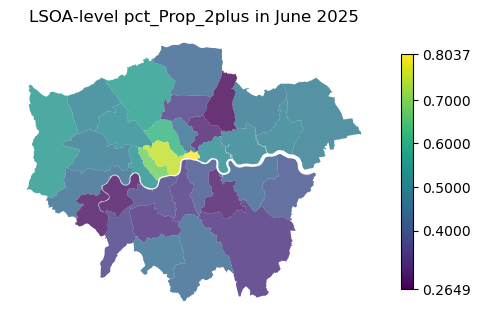

In [146]:
vis_df = temp_lad.copy()
#vis_df = gdf_lsoa.copy()
#col = 'sum_high_risk'
col = 'pct_Prop_2plus'
#vis_df[col] = vis_df['sum_high_risk']*100/vis_df['listings_count']
t_m, t_y = 'June', 2025

min_scale, max_scale = vis_df[col].min(), vis_df[col].max()
gap = 5

fig, ax = plt.subplots(figsize=(5, 5))

vis_df.plot(
    column=col,
    categorical=False,
    legend=True,
    alpha=0.8,
    ax=ax,
    vmin=min_scale, 
    vmax=max_scale,
    legend_kwds={"shrink": 0.5, "ticks": list(make_ticks(min_scale,max_scale, gap))}
)

ax.set_title(f"LSOA-level {col} in {t_m} {t_y}")
ax.set_axis_off()

plt.tight_layout()
plt.show()

In [ ]:
temp_lad["Prop_2plus"]

## This one is still waiting to be added.
Here is the sample image from Arthur's code. I haven't finished implementing them yet

![alt text](sample_network.png "Title")

# 4. What are the likely pros and cons of the opposition’s proposal (for the Mayor, for residents, and for the city)?

We believed

# 5. Can the story be reframed as a positive one about social mobility or housing opportunity?

The story can still be seen as more neutral rather than negative as framed by the opposition. Despite a large number of short-term entire-property listings not compiling with the 90-day rule and operated by the hosts with multiple listings. Yet, the share of these 

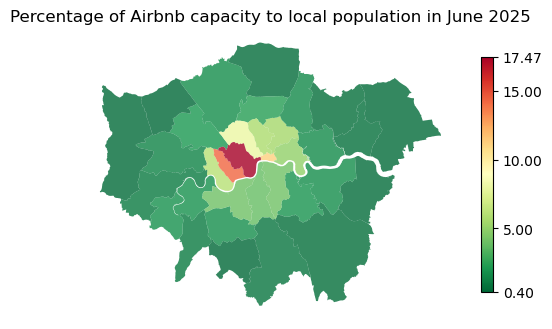

In [26]:
vis_df = gdf_lad.copy()
#col = 'sum_high_risk'
col = 'Percentage of Airbnb capacity to local population'
vis_df[col] = vis_df['accom_sum']*100/vis_df['total_2024']
t_m, t_y = 'June', 2025

min_scale, max_scale = vis_df[col].min(), vis_df[col].max()
#min_scale, max_scale = 0, 30
gap = 5

fig, ax = plt.subplots(figsize=(5, 5))

vis_df.plot(
    column=col,
    categorical=False,
    legend=True,
    cmap="RdYlGn_r", 
    alpha=0.8,
    #norm = TwoSlopeNorm(vcenter=0, vmin=min_scale, vmax=max_scale),
    ax=ax,
    vmin=min_scale, 
    vmax=max_scale,
    legend_kwds={"shrink": 0.5, "ticks": list(make_ticks(min_scale, max_scale, gap))},
    missing_kwds={"color": "lightgrey", "edgecolor": None,"label": "No data"}
)

ax.set_title(f"{col} in {t_m} {t_y}")
ax.set_axis_off()

plt.tight_layout()
plt.show()

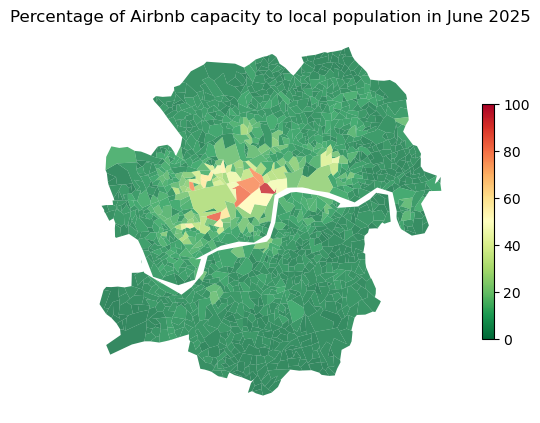

In [17]:
central_london_borough = ["City of London", "Westminster", "Kensington and Chelsea", "Camden", "Islington", "Hackney", 
                          "Hammersmith and Fulham", "Lambeth", "Southwark", "Tower Hamlets", "Wandsworth"]

vis_df = gdf_lsoa.copy()
vis_df = vis_df[vis_df['LAD25NM'].isin(central_london_borough)]
#col = 'sum_high_risk'
col = 'Percentage of Airbnb capacity to local population'
vis_df[col] = vis_df['accom_sum']*100/vis_df['total_2024']
t_m, t_y = 'June', 2025

#min_scale, max_scale = vis_df[col].min(), vis_df[col].max()
min_scale, max_scale = 0, 100
gap = 5

fig, ax = plt.subplots(figsize=(5, 5))

vis_df.plot(
    column=col,
    categorical=False,
    legend=True,
    cmap="RdYlGn_r", 
    alpha=0.8,
    ax=ax,
    vmin=min_scale, 
    vmax=max_scale,
    legend_kwds={"shrink": 0.5, "ticks": list(make_ticks(0,100, gap))},
    missing_kwds={"color": "lightgrey", "edgecolor": None, "label": "No data"}
)

ax.set_title(f"{col} in {t_m} {t_y}")
ax.set_axis_off()

plt.tight_layout()
plt.show()

Arthur's work on 

# Unused Codes: can be deleted?

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_40508\533834197.py:78: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


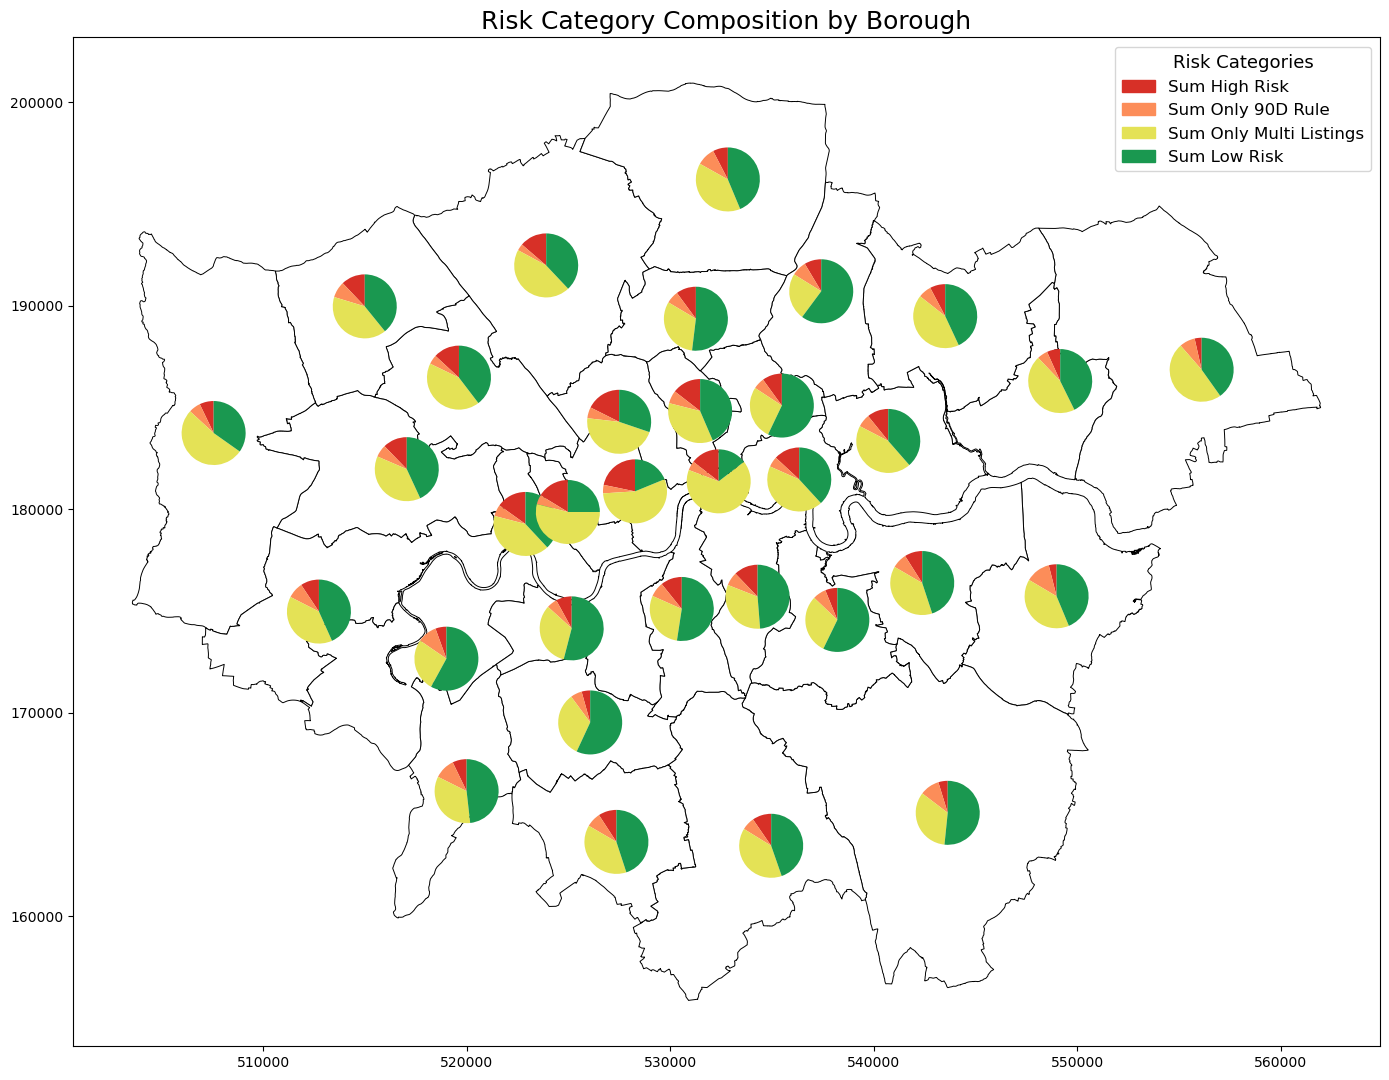

In [231]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as mpatches

# Risk columns in the order you want them displayed
risk_cols = [
    'sum_high_risk',
    'sum_only_90d_rule',
    'sum_only_multi_listings',
    'sum_low_risk'
]

# Custom colours for good separation
# You can adjust these if you want a different palette
colours = {
    'sum_high_risk': "#d73027",          # red
    'sum_only_90d_rule': "#fc8d59",      # orange
    'sum_only_multi_listings': "#e4e256",# yellow
    'sum_low_risk': "#1a9850"            # green
}

# Use representative points to improve placement
df["rep_pt"] = df.geometry.representative_point()

fig, ax = plt.subplots(1, 1, figsize=(14, 14))

# Base map
df.plot(ax=ax, color="white", edgecolor="black", linewidth=0.7)

# Loop over each borough and draw its pie
for _, row in df.iterrows():

    values = row[risk_cols].values
    if values.sum() == 0:
        continue

    x, y = row["rep_pt"].x, row["rep_pt"].y

    # Place a slightly larger pie: width/height between 0.07–0.10 usually works
    ax_ins = inset_axes(
        ax,
        width=0.8,
        height=0.8,
        loc="center",
        bbox_to_anchor=(x, y),
        bbox_transform=ax.transData,
        borderpad=0,
    )

    # Pie chart
    ax_ins.pie(
        values,
        colors=[colours[col] for col in risk_cols],
        startangle=90,
        wedgeprops={"linewidth": 0}
    )
    ax_ins.set_aspect("equal")
    ax_ins.axis("off")

# -----------------------
# Add Legend
# -----------------------
legend_patches = [
    mpatches.Patch(color=colours[col], label=col.replace('_', ' ').title())
    for col in risk_cols
]

plt.legend(
    handles=legend_patches,
    title="Risk Categories",
    loc="lower left",
    bbox_to_anchor=(6.5, 4.5),   # Push legend outside map
    borderaxespad=0,
    fontsize=12,
    title_fontsize=13
)

ax.set_title("Risk Category Composition by Borough", fontsize=18)
plt.tight_layout()
plt.show()
